# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from MetabolomicsPaper.GeneralHelperFunctions import *
from sklearn.model_selection import train_test_split

paper_dir = '/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/Paper_v4/'
curr_dir = os.path.join(paper_dir, 'metabolite_exclusion')
make_dir_if_not_exists(curr_dir)
os.chdir(curr_dir)

# Load data

In [3]:
metabs1 = pd.read_csv(os.path.join(paper_dir, 'dataframes/metabs1.csv'), index_col=0)
updated_metabs1 = pd.read_csv(os.path.join(paper_dir, 'dataframes/updated_metabs1.csv'), index_col=0)
mar17_features = pd.read_csv(os.path.join(paper_dir, 'dataframes/mar17_features.csv'), index_col=0)
# metabolomics = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/technical_noise/dataframes/mar17_metabolomics_unnormed_fillna_min_dayfromfirstsample_regressed_rzs.csv', index_col=0)
metabolomics = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/SHAP/dataframes/mar17_metabolomics_unnormed_fillna_min_dayfromfirstsample_regressed_rzs.csv', index_col=0)

# Compute pvalues

In [6]:
technical_noise = pd.DataFrame()

ml0 = mar17_features[mar17_features['Meeting_Location'] == 0].index
ml1 = mar17_features[mar17_features['Meeting_Location'] == 1].index
ml_p = metabolomics.apply(lambda x: mannwhitneyu(x.loc[ml0], x.loc[ml1])[1])

sam = mar17_features[mar17_features['SampledAtMorning'] == True].index
sae = mar17_features[mar17_features['SampledAtMorning'] == False].index
sam_p = metabolomics.apply(lambda x: mannwhitneyu(x.loc[sam], x.loc[sae])[1])

ml1_sam = mar17_features[((mar17_features['Meeting_Location'] == 1) & (mar17_features['SampledAtMorning'] == True))].index
ml1_sae = mar17_features[((mar17_features['Meeting_Location'] == 1) & (mar17_features['SampledAtMorning'] == False))].index
sam_tlv_p = metabolomics.apply(lambda x: mannwhitneyu(x.loc[ml1_sam], x.loc[ml1_sae])[1])

ml0_sam = mar17_features[((mar17_features['Meeting_Location'] == 0) & (mar17_features['SampledAtMorning'] == True))].index
ml1_sam = mar17_features[((mar17_features['Meeting_Location'] == 1) & (mar17_features['SampledAtMorning'] == True))].index
mls_p = metabolomics.apply(lambda x: mannwhitneyu(x.loc[ml0_sam], x.loc[ml1_sam])[1])

technical_noise['MeetingLocationAll_pval'] = ml_p
technical_noise['SampledAtMorningTLV_pval'] = sam_tlv_p
technical_noise['MeetingLocationMorning_pval'] = mls_p
technical_noise['SampledAtMorningAll_pval'] = sam_p

# plot

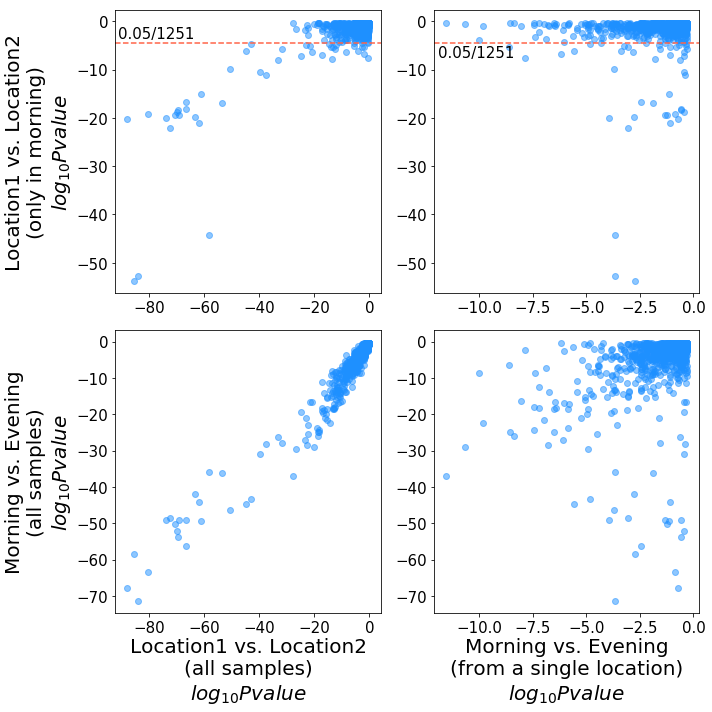

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=False, sharey=False)

pval_th = np.log10(0.05/1251)
log_pval_str = '\n$log_{10}P value$'

ax = axes[0, 0]
ax.plot(technical_noise['MeetingLocationAll_pval'].apply(np.log10), technical_noise['MeetingLocationMorning_pval'].apply(np.log10), 'o', alpha=0.5, color='dodgerblue')
ax.axhline(y=pval_th, ls='--', label='0.05/1251', color='tomato')
ax.text(ax.get_xlim()[0]+1, pval_th+1, '0.05/1251', fontsize=15)
# ax.set_xlabel('Location1 vs. Location2\n(all samples)' + log_pval_str, fontsize=20)
ax.set_ylabel('Location1 vs. Location2\n(only in morning)' + log_pval_str, fontsize=20)
ax.tick_params(labelsize=15)

ax = axes[0, 1]
ax.plot(technical_noise['SampledAtMorningTLV_pval'].apply(np.log10), technical_noise['MeetingLocationMorning_pval'].apply(np.log10), 'o', alpha=0.5, color='dodgerblue')
# ax.set_xlabel('Morning vs. Evening\n(from a single location)' + log_pval_str, fontsize=20)
# ax.set_ylabel('Location1 vs. Location2\n(only in morning)' + log_pval_str, fontsize=20)
ax.axhline(y=pval_th, ls='--', label='0.05/1251', color='tomato')
ax.text(ax.get_xlim()[0]+0.2, pval_th-3, '0.05/1251', fontsize=15)
ax.tick_params(labelsize=15)

ax = axes[1, 0]
ax.plot(technical_noise['MeetingLocationAll_pval'].apply(np.log10), technical_noise['SampledAtMorningAll_pval'].apply(np.log10), 'o', alpha=0.5, color='dodgerblue')
ax.set_xlabel('Location1 vs. Location2\n(all samples)' + log_pval_str, fontsize=20)
ax.set_ylabel('Morning vs. Evening\n(all samples)' + log_pval_str, fontsize=20)
ax.tick_params(labelsize=15)

ax = axes[1, 1]
ax.plot(technical_noise['SampledAtMorningTLV_pval'].apply(np.log10), technical_noise['SampledAtMorningAll_pval'].apply(np.log10), 'o', alpha=0.5, color='dodgerblue')
ax.set_xlabel('Morning vs. Evening\n(from a single location)' + log_pval_str, fontsize=20)
# ax.set_ylabel('Morning vs. Evening\n(all samples)' + log_pval_str, fontsize=20)
ax.tick_params(labelsize=15)

fig.tight_layout()
plt.savefig(os.path.join('Identifying_problematic_metabolites_scatterplots.png'), dpi=500)